# Model training(continued)

We have so far gathered a dataset of 100,000 uniformly drawn datapoints, a dataset of 20000 near-boundary datapoints by bisection, and implemented CustomLoss to account for normality condition near boundary. We summarize model training here and try to observe performance under different conditions. Furthermore, we will do hyperparameter tuning to try to improve the model with CustomLoss.

## Preparation

In [1]:
import numpy as np
import math
import pandas as pd

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [2]:
## Load the dataset
class LorenzDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = torch.tensor([self.data.iloc[idx].x0, self.data.iloc[idx].y0, self.data.iloc[idx].z0]).float()
        label = torch.tensor(self.data.iloc[idx].attracted).float()
        return features, label
    
dataset_uniform = LorenzDataset("dataset_large.csv")
dataset_near = LorenzDataset("dataset_near.csv")

## Prepare separated and merged datasets
dataset_uniform_train, dataset_uniform_test = torch.utils.data.random_split(dataset_uniform, [80000, 20000])
dataset_near_train, dataset_near_test = torch.utils.data.random_split(dataset_near, [16000, 4000])
dataset_train_merged = torch.utils.data.ConcatDataset([dataset_uniform_train, dataset_near_train])
dataset_test_merged = torch.utils.data.ConcatDataset([dataset_uniform_test, dataset_near_test])



In [3]:
## Define the neural network. The complexity of the network is a hyperparameter.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3,128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x
    
net = Net()

In [4]:
class CustomLoss(nn.Module):
    def __init__(self, magnitude, threshold):
        super(CustomLoss, self).__init__()
        self.magnitude = magnitude
        self.threshold = threshold

    def forward(self, predictions, labels, inputs, b):
        l = nn.BCELoss()
        l = l(predictions.squeeze(), labels)

        near_condition = (predictions > 0.5 - self.threshold) & (predictions < 0.5 + self.threshold)
        near_points_prediction = predictions[near_condition]
        near_points_input = inputs[near_condition].clone().detach().requires_grad_(True)
        grads = torch.autograd.grad(near_points_prediction.sum(), near_points_input, create_graph=True, allow_unused=True)[0]
        
        if grads is not None:
            norm_grads = grads / grads.norm(dim = 1, keepdim=True)
            norm_b = b / b.norm(dim=1, keepdim=True)
            inner_product = (norm_grads * norm_b).sum(dim=1)
            inner_product = inner_product ** 2
            l += self.magnitude * inner_product
        
        return l

In [5]:
def lorenz(t, X, sigma=10, beta=8/3, r=10):
    """The Lorenz equations."""
    x, y, z = X
    xp = sigma*(y - x)
    yp = r*x - y - x*z
    zp = -beta*z + x*y
    return xp, yp, zp

In [6]:
def train_model_bce(net, dataset_train, batchsize, epochs, lr):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    for epoch in range(epochs):
        running_loss = 0.0
        mini_batch_count = 0
        for features, labels in dataloader_train:
            labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            mini_batch_count += 1
        print('Finished training for epoch %d, loss: %.3f' % (epoch + 1, running_loss / mini_batch_count))
    return net
    
def train_model_custom(net, dataset_train, batchsize, epochs, lr, magnitude, threshold):
    criterion = CustomLoss(magnitude, threshold)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    for epoch in range(epochs):
        running_loss = 0.0
        mini_batch_count = 0
        for features, labels in dataloader_train:
            labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            loss = criterion(outputs, labels, features, lorenz(0, features.T))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            mini_batch_count += 1
        print('Finished training for epoch %d, loss: %.3f' % (epoch + 1, running_loss / mini_batch_count))
    return net

def test_model(net, dataset_test):
    dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)
    features_list = []
    labels_list = []
    probability_list = []
    predictions_list = []
    acc = Accuracy(task = 'binary')

    with torch.no_grad():
        for features, labels in dataloader_test:
            labels = ((labels + 1) / 2).float()
            probability = net(features)
            outputs = (probability > 0.5).float()
            outputs = outputs.squeeze()

            acc.update(outputs, labels)

            # Move features, labels, and outputs to CPU and convert them to numpy arrays
            features_list.append(features.numpy())
            labels_list.append(labels.numpy())
            probability_list.append(probability.numpy())
            predictions_list.append(outputs.numpy())
    accuracy = acc.compute()
    print(f'Accuracy: {accuracy}')

    # Concatenate all batches
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    probability = np.concatenate(probability_list, axis=0)
    predictions = np.concatenate(predictions_list, axis=0)

    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the features colored by the predictions
    scatter = ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=probability, cmap='coolwarm')

    # Add a color bar
    plt.colorbar(scatter)

    plt.show()

    plt.hist(probability, bins=100)
    plt.show()

## Training with uniform data only

In [7]:
net_uniform_bce = Net()
net_uniform_custom = Net()

In [8]:
net_uniform_bce = train_model_bce(net_uniform_bce, dataset_uniform_train, 32, 100, 0.001)

Finished training for epoch 1, loss: 0.643
Finished training for epoch 2, loss: 0.600
Finished training for epoch 3, loss: 0.472
Finished training for epoch 4, loss: 0.305
Finished training for epoch 5, loss: 0.251
Finished training for epoch 6, loss: 0.221
Finished training for epoch 7, loss: 0.203
Finished training for epoch 8, loss: 0.184
Finished training for epoch 9, loss: 0.172
Finished training for epoch 10, loss: 0.164
Finished training for epoch 11, loss: 0.155
Finished training for epoch 12, loss: 0.148
Finished training for epoch 13, loss: 0.146
Finished training for epoch 14, loss: 0.143
Finished training for epoch 15, loss: 0.135
Finished training for epoch 16, loss: 0.135
Finished training for epoch 17, loss: 0.129
Finished training for epoch 18, loss: 0.129
Finished training for epoch 19, loss: 0.127
Finished training for epoch 20, loss: 0.121
Finished training for epoch 21, loss: 0.122
Finished training for epoch 22, loss: 0.119
Finished training for epoch 23, loss: 0.1

Accuracy: 0.9576500058174133


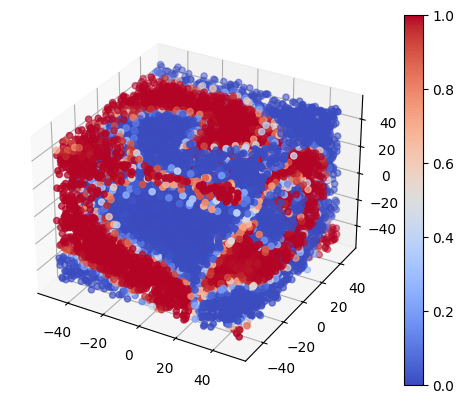

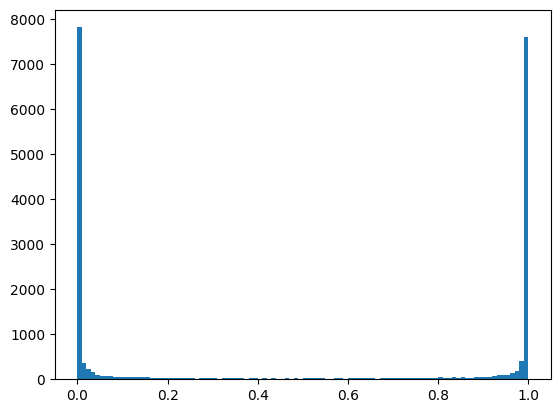

In [9]:
test_model(net_uniform_bce, dataset_uniform_test)

Accuracy: 0.4997499883174896


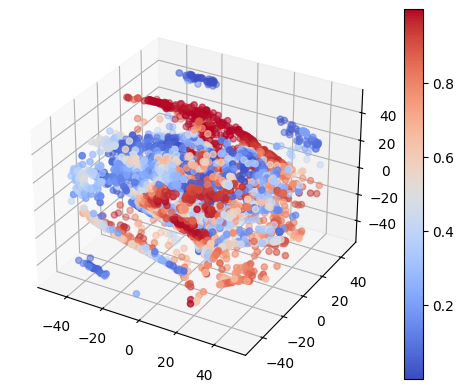

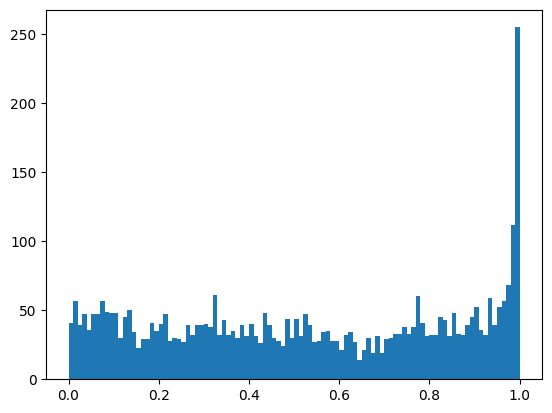

In [10]:
test_model(net_uniform_bce, dataset_near_test)

Accuracy: 0.8813333511352539


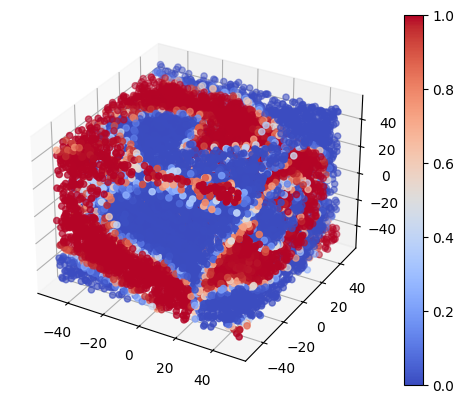

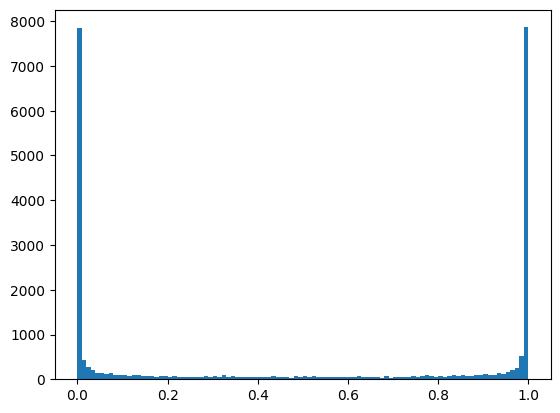

In [11]:
test_model(net_uniform_bce, dataset_test_merged)

In [12]:
net_uniform_custom = train_model_custom(net_uniform_custom, dataset_uniform_train, 32, 100, 0.001, 100, 0.01)

Finished training for epoch 1, loss: 0.640
Finished training for epoch 2, loss: 0.607
Finished training for epoch 3, loss: 0.504
Finished training for epoch 4, loss: 0.303
Finished training for epoch 5, loss: 0.234
Finished training for epoch 6, loss: 0.209
Finished training for epoch 7, loss: 0.196
Finished training for epoch 8, loss: 0.182
Finished training for epoch 9, loss: 0.171
Finished training for epoch 10, loss: 0.158
Finished training for epoch 11, loss: 0.151
Finished training for epoch 12, loss: 0.145
Finished training for epoch 13, loss: 0.141
Finished training for epoch 14, loss: 0.136
Finished training for epoch 15, loss: 0.132
Finished training for epoch 16, loss: 0.132
Finished training for epoch 17, loss: 0.128
Finished training for epoch 18, loss: 0.127
Finished training for epoch 19, loss: 0.123
Finished training for epoch 20, loss: 0.123
Finished training for epoch 21, loss: 0.120
Finished training for epoch 22, loss: 0.118
Finished training for epoch 23, loss: 0.1

Accuracy: 0.9673500061035156


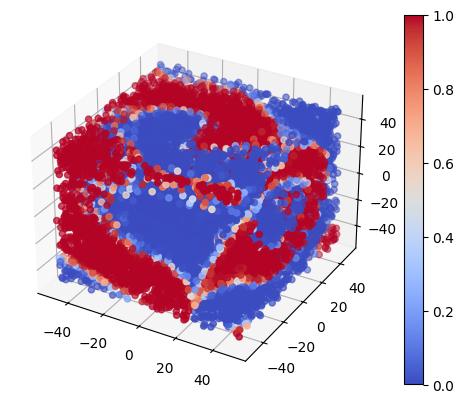

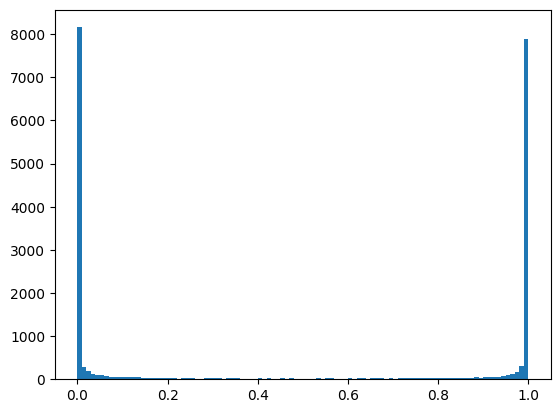

In [13]:
test_model(net_uniform_custom, dataset_uniform_test)

Accuracy: 0.4932500123977661


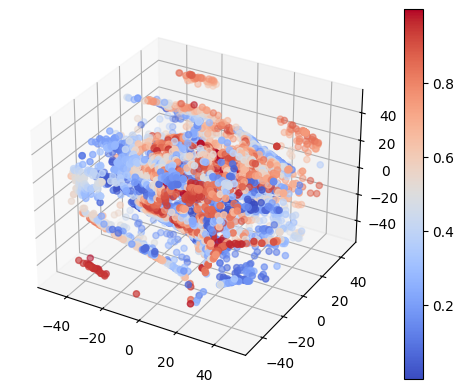

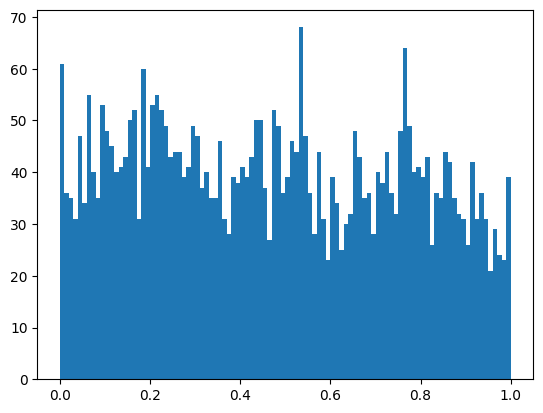

In [14]:
test_model(net_uniform_custom, dataset_near_test)

Accuracy: 0.8883333206176758


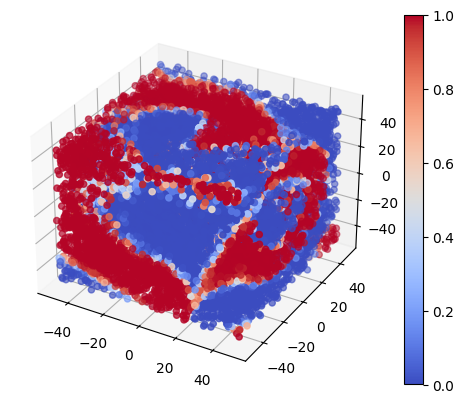

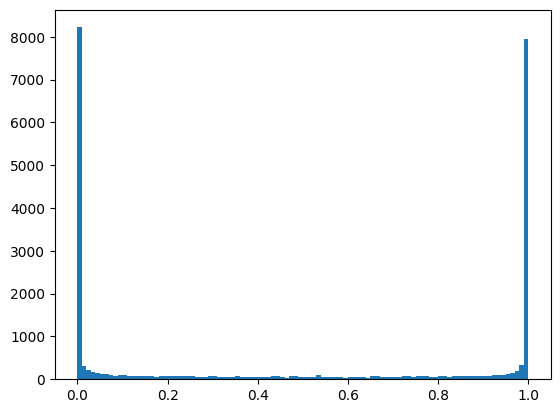

In [15]:
test_model(net_uniform_custom, dataset_test_merged)

## Training with near data only

In [16]:
net_near_bce = Net()
net_near_custom = Net()

In [17]:
net_near_bce = train_model_bce(net_near_bce, dataset_near_train, 32, 100, 0.001)

Finished training for epoch 1, loss: 0.704
Finished training for epoch 2, loss: 0.694
Finished training for epoch 3, loss: 0.694
Finished training for epoch 4, loss: 0.693
Finished training for epoch 5, loss: 0.693
Finished training for epoch 6, loss: 0.694
Finished training for epoch 7, loss: 0.694
Finished training for epoch 8, loss: 0.693
Finished training for epoch 9, loss: 0.693
Finished training for epoch 10, loss: 0.693
Finished training for epoch 11, loss: 0.693
Finished training for epoch 12, loss: 0.693
Finished training for epoch 13, loss: 0.693
Finished training for epoch 14, loss: 0.693
Finished training for epoch 15, loss: 0.693
Finished training for epoch 16, loss: 0.693
Finished training for epoch 17, loss: 0.693
Finished training for epoch 18, loss: 0.693
Finished training for epoch 19, loss: 0.693
Finished training for epoch 20, loss: 0.693
Finished training for epoch 21, loss: 0.693
Finished training for epoch 22, loss: 0.693
Finished training for epoch 23, loss: 0.6

Accuracy: 0.5037000179290771


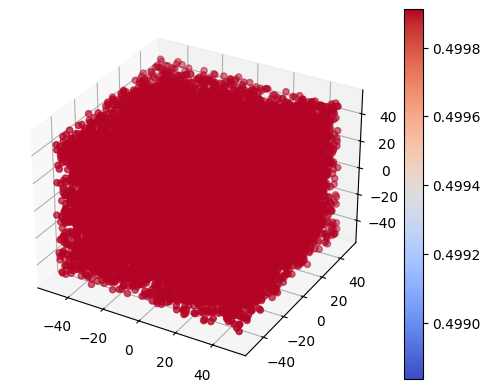

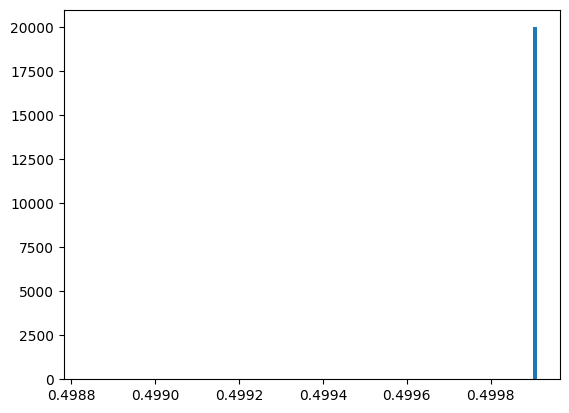

In [18]:
test_model(net_near_bce, dataset_uniform_test)

Accuracy: 0.4984999895095825


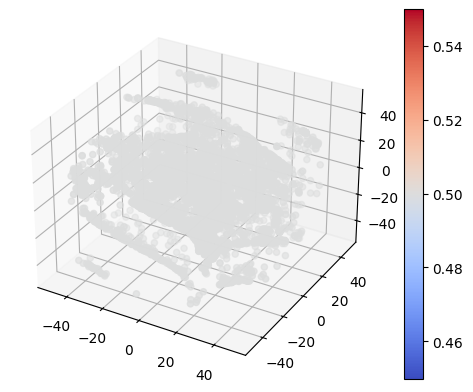

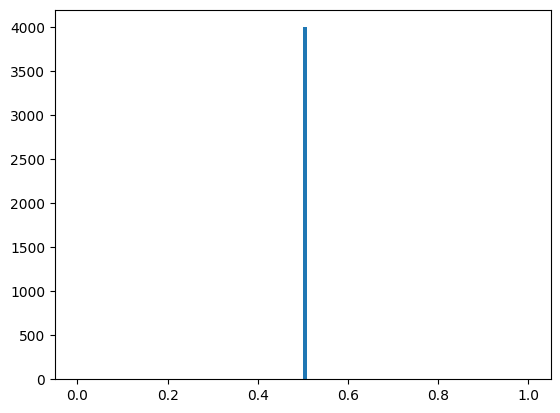

In [19]:
test_model(net_near_bce, dataset_near_test)

Accuracy: 0.5028333067893982


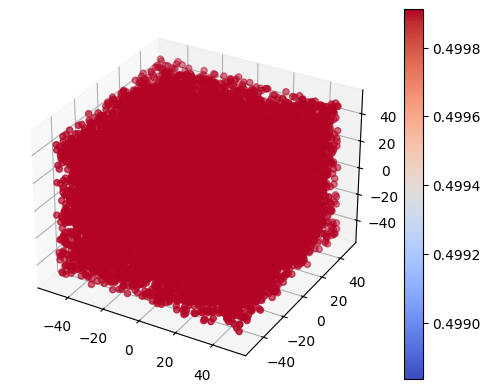

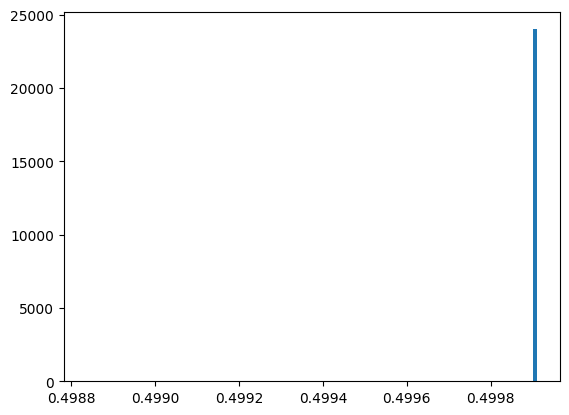

In [20]:
test_model(net_near_bce, dataset_test_merged)

In [21]:
net_near_custom = train_model_custom(net_near_custom, dataset_near_train, 32, 100, 0.001, 100, 0.01)

Finished training for epoch 1, loss: 0.702
Finished training for epoch 2, loss: 0.694
Finished training for epoch 3, loss: 0.693
Finished training for epoch 4, loss: 0.693
Finished training for epoch 5, loss: 0.693
Finished training for epoch 6, loss: 0.693
Finished training for epoch 7, loss: 0.693
Finished training for epoch 8, loss: 0.693
Finished training for epoch 9, loss: 0.693
Finished training for epoch 10, loss: 0.693
Finished training for epoch 11, loss: 0.693
Finished training for epoch 12, loss: 0.693
Finished training for epoch 13, loss: 0.693
Finished training for epoch 14, loss: 0.693
Finished training for epoch 15, loss: 0.693
Finished training for epoch 16, loss: 0.693
Finished training for epoch 17, loss: 0.693
Finished training for epoch 18, loss: 0.693
Finished training for epoch 19, loss: 0.693
Finished training for epoch 20, loss: 0.693
Finished training for epoch 21, loss: 0.693
Finished training for epoch 22, loss: 0.693
Finished training for epoch 23, loss: 0.6

Accuracy: 0.49630001187324524


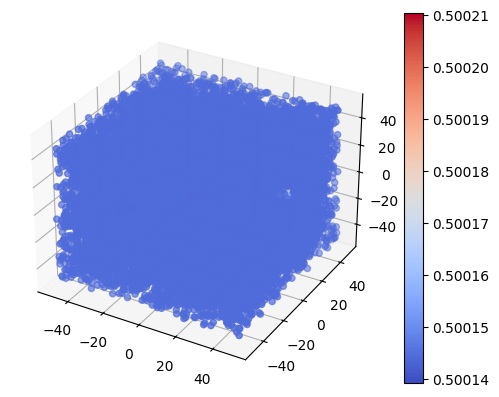

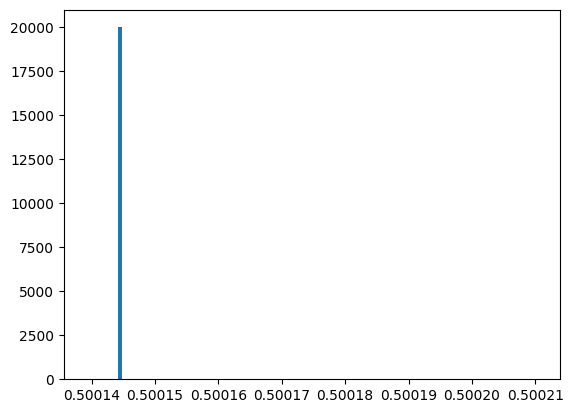

In [22]:
test_model(net_near_custom, dataset_uniform_test)

Accuracy: 0.5015000104904175


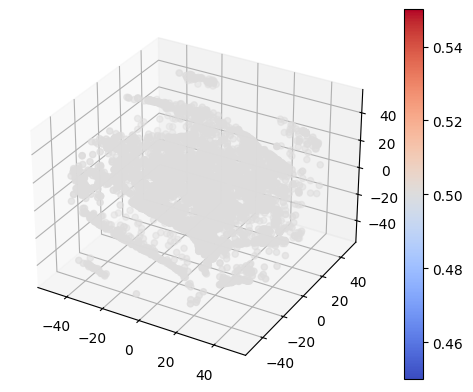

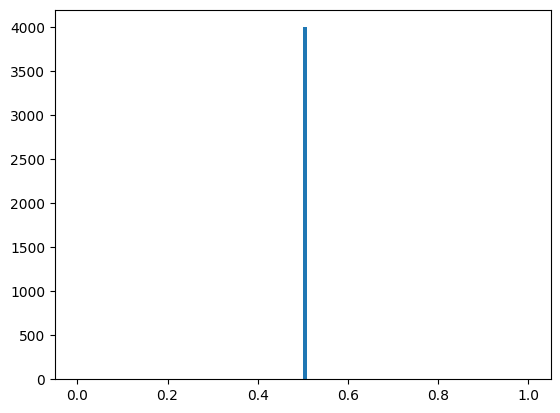

In [23]:
test_model(net_near_custom, dataset_near_test)

Accuracy: 0.4971666634082794


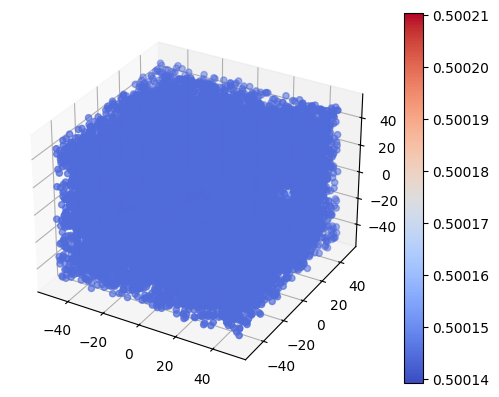

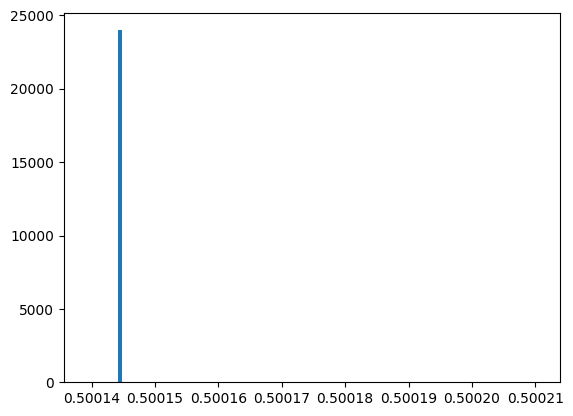

In [24]:
test_model(net_near_custom, dataset_test_merged)

## Training with mixed data

In [25]:
net_mixed_bce = Net()
net_mixed_custom = Net()

In [26]:
net_mixed_bce = train_model_bce(net_mixed_bce, dataset_train_merged, 32, 100, 0.001)

Finished training for epoch 1, loss: 0.658
Finished training for epoch 2, loss: 0.628
Finished training for epoch 3, loss: 0.564
Finished training for epoch 4, loss: 0.444
Finished training for epoch 5, loss: 0.374
Finished training for epoch 6, loss: 0.353
Finished training for epoch 7, loss: 0.337
Finished training for epoch 8, loss: 0.323
Finished training for epoch 9, loss: 0.309
Finished training for epoch 10, loss: 0.295
Finished training for epoch 11, loss: 0.285
Finished training for epoch 12, loss: 0.278
Finished training for epoch 13, loss: 0.274
Finished training for epoch 14, loss: 0.270
Finished training for epoch 15, loss: 0.268
Finished training for epoch 16, loss: 0.263
Finished training for epoch 17, loss: 0.260
Finished training for epoch 18, loss: 0.256
Finished training for epoch 19, loss: 0.253
Finished training for epoch 20, loss: 0.251
Finished training for epoch 21, loss: 0.251
Finished training for epoch 22, loss: 0.246
Finished training for epoch 23, loss: 0.2

Accuracy: 0.9613500237464905


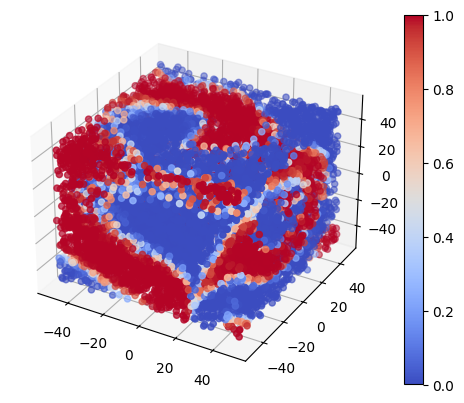

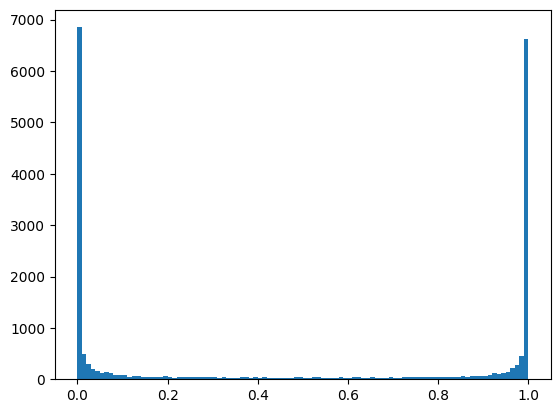

In [27]:
test_model(net_mixed_bce, dataset_uniform_test)

Accuracy: 0.4882499873638153


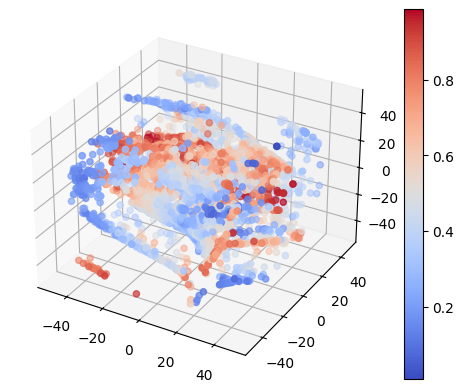

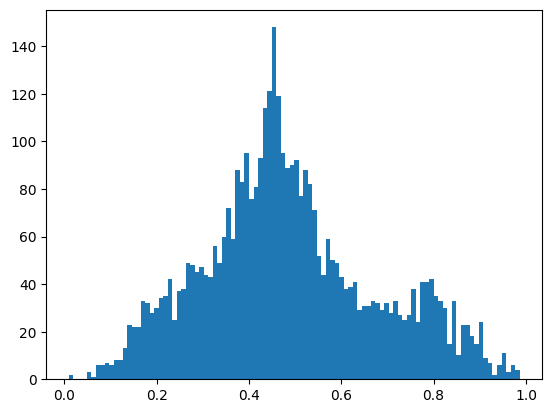

In [28]:
test_model(net_mixed_bce, dataset_near_test)

Accuracy: 0.8824999928474426


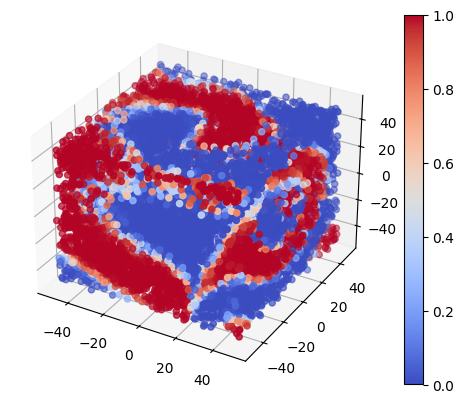

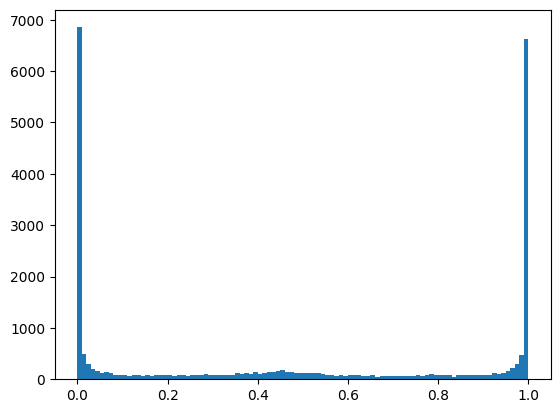

In [29]:
test_model(net_mixed_bce, dataset_test_merged)

In [30]:
net_mixed_custom = train_model_custom(net_mixed_custom, dataset_train_merged, 32, 100, 0.001, 100, 0.01)

Finished training for epoch 1, loss: 0.657
Finished training for epoch 2, loss: 0.629
Finished training for epoch 3, loss: 0.553
Finished training for epoch 4, loss: 0.399
Finished training for epoch 5, loss: 0.344
Finished training for epoch 6, loss: 0.317
Finished training for epoch 7, loss: 0.303
Finished training for epoch 8, loss: 0.291
Finished training for epoch 9, loss: 0.285
Finished training for epoch 10, loss: 0.275
Finished training for epoch 11, loss: 0.271
Finished training for epoch 12, loss: 0.263
Finished training for epoch 13, loss: 0.260
Finished training for epoch 14, loss: 0.257
Finished training for epoch 15, loss: 0.253
Finished training for epoch 16, loss: 0.250
Finished training for epoch 17, loss: 0.248
Finished training for epoch 18, loss: 0.244
Finished training for epoch 19, loss: 0.241
Finished training for epoch 20, loss: 0.242
Finished training for epoch 21, loss: 0.241
Finished training for epoch 22, loss: 0.237
Finished training for epoch 23, loss: 0.2

Accuracy: 0.9588000178337097


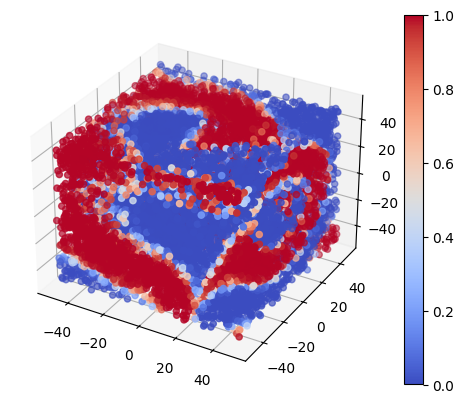

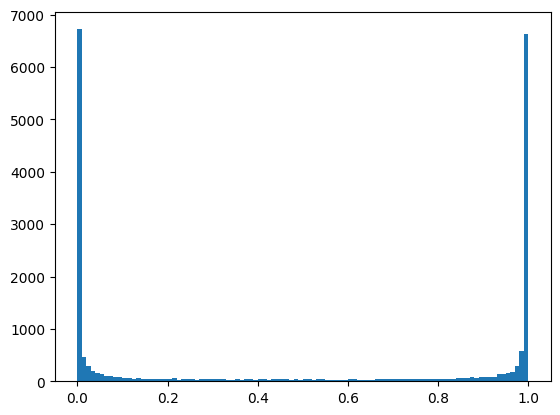

In [31]:
test_model(net_mixed_custom, dataset_uniform_test)

Accuracy: 0.47874999046325684


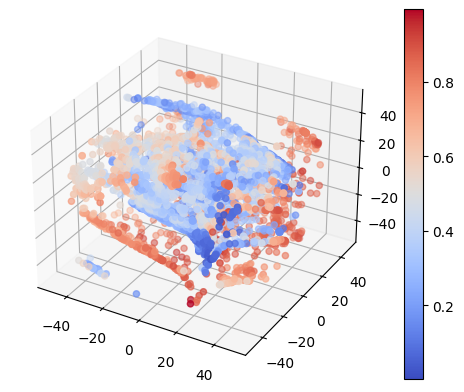

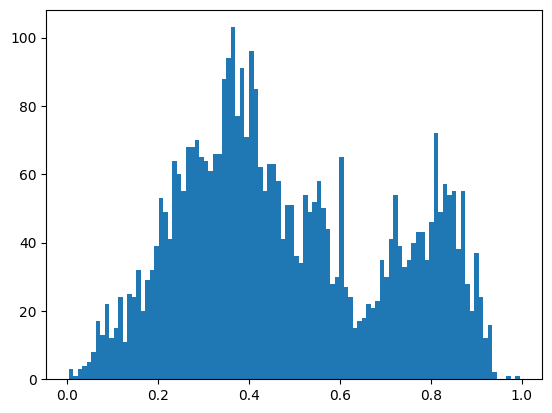

In [32]:
test_model(net_mixed_custom, dataset_near_test)

Accuracy: 0.8787916898727417


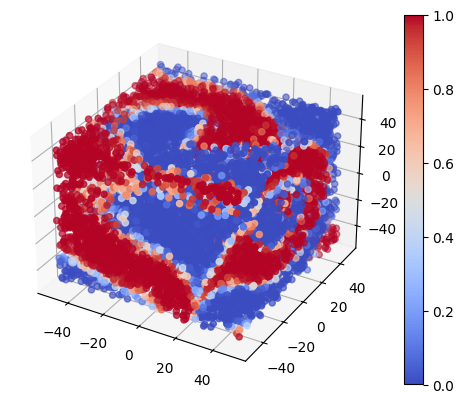

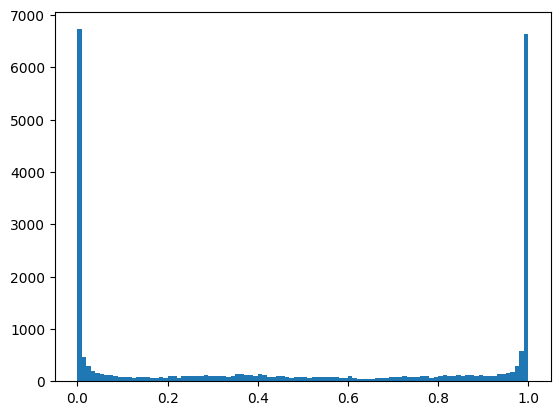

In [33]:
test_model(net_mixed_custom, dataset_test_merged)

In [34]:
## Save the models
torch.save(net_uniform_bce.state_dict(), 'net_uniform_bce.pth')
torch.save(net_uniform_custom.state_dict(), 'net_uniform_custom.pth')
torch.save(net_near_bce.state_dict(), 'net_near_bce.pth')
torch.save(net_near_custom.state_dict(), 'net_near_custom.pth')
torch.save(net_mixed_bce.state_dict(), 'net_mixed_bce.pth')
torch.save(net_mixed_custom.state_dict(), 'net_mixed_custom.pth')
